# Recommendations with IBM

In this notebook, we will build out a number of different methods for making recommendations for users, based on real data from the IBM Watson Studio platform.


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

In [2]:
#load data
df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')

#remove unncessary columns
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
email         45976 non-null object
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [5]:
df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1042 non-null object
doc_description    1053 non-null object
doc_full_name      1056 non-null object
doc_status         1056 non-null object
article_id         1056 non-null int64
dtypes: int64(1), object(4)
memory usage: 41.3+ KB


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?

In [6]:
df.article_id.describe()

count    45993.000000
mean       908.846477
std        486.647866
min          0.000000
25%        460.000000
50%       1151.000000
75%       1336.000000
max       1444.000000
Name: article_id, dtype: float64

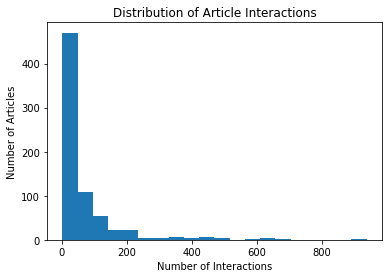

In [7]:
plt.hist(df.article_id.value_counts(), bins = 20)
plt.gca().set(title='Distribution of Article Interactions', ylabel='Number of Articles', xlabel = 'Number of Interactions');

In [8]:
df

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2
5,1432.0,visualize data with the matplotlib library,b32cd4e1a74e55ac42e4ef484b1f0ad41ee3b1c5
6,1429.0,use deep learning for image classification,3c2de1b0a92728aa53064a22ff7bd7319878ed95
7,593.0,upload files to ibm data science experience us...,3bbca9c41c66c4ecc46bc14eac7b7ab1ab0a5bea
8,1314.0,healthcare python streaming application demo,8b6fb4bbb7a27b336ba35420bf58337d877455c7
9,1185.0,classify tumors with machine learning,35d5799b6ea3ba24f921ed38f7f9a8039ad06ba4


In [9]:
df_ids = df.article_id.value_counts().index.tolist()
content_ids = df_content.article_id.value_counts().index.tolist()

what is the meaning of the discrepancies of the ids in df_content vs df as seen below?

In [10]:
#there are 714 ids in df
len(df_ids)

714

In [11]:
#There are 1051 ids in content
len(content_ids)

1051

In [12]:
#there are 277 ids in df that aren't in content
len(set(df_ids).difference(set(content_ids)))

277

In [13]:
#there are 614 ids in content that aren't in df
len(set(content_ids).difference(set(df_ids)))

614

In [14]:
# median and maximum number of user_article interactios

median_val = df['email'].value_counts().median() # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = df['email'].value_counts().max() # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [15]:
def get_duplicates(df,col):
    value_counts = df[col].value_counts()
    dups = value_counts[value_counts>1].index.tolist()
    return df[df[col].isin(dups)].sort_values(col)

In [16]:
# Find and explore duplicate articles

#dropping any rows that are complete duplicates
df_content.drop_duplicates(inplace=True)

#inspecting article ids that still appear more than once
get_duplicates(df_content, 'article_id')

,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577


In [17]:
# Remove any rows that have the same article_id - only keep the first

In [18]:
#For the duplicates above, keeping the first of each duplicate
df_content.drop([365,692,971,761,970],inplace = True)

In [19]:
#even though these have duplicate doc_body, it seems like these should still be considered seperate articles, so not deleting anything
get_duplicates(df_content, 'doc_body')

,doc_body,doc_description,doc_full_name,doc_status,article_id
244,* Select a country/region: United States\r\n\r...,"Data exploration and analysis is a repetitive,...",Notebooks: A power tool for data scientists,Live,244
474,* Select a country/region: United States\r\n\r...,Machine learning is changing not only how we ...,Intelligent applications - Apache Spark,Live,473
564,Cheat sheet,The RStudio IDE is the most popular integrated...,RStudio IDE Cheat Sheet,Live,563
678,Cheat sheet,The devtools package makes it easy to build yo...,Package Development with devtools Cheat Sheet,Live,677
892,Need to report the video?\r\n\r\nSign in to re...,Video tutorial showing the complete creation o...,Mobile App Webinar Demo,Live,889
997,Need to report the video?\r\n\r\nSign in to re...,Using Cloudant and MobileFirst services on Blu...,Building a MobileFirst App on IBM Bluemix,Live,992
33,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,Analytics and visualization often go hand-in-h...,Using Brunel in IPython/Jupyter Notebooks,Live,33
369,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,After shoveling the driveway several times and...,Snowzilla!,Live,368
885,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,How to create a blog entry using Brunel in a f...,Blogging With Brunel,Live,882
1020,Working Vis * \r\n * \r\n\r\n * Home\r\n * Abo...,The two main new features of Brunel 0.8 are an...,Enhanced Color mapping,Live,1015


In [20]:
#even though these have duplicate doc_description, it seems like these should still be considered seperate articles, so not deleting anything
get_duplicates(df_content, 'doc_description')

,doc_body,doc_description,doc_full_name,doc_status,article_id
884,* Home\r\n * Research\r\n * Partnerships and C...,"Every two weeks, we find the most interesting ...",Web Picks (week of 2 October 2017),Live,881
607,* Home\r\n * Research\r\n * Partnerships and C...,"Every two weeks, we find the most interesting ...",Web Picks (December 2017),Live,606
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
560,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 4, 2017)",Live,559
304,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (August 30, 2016)",Live,304
288,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (January 31, 2017)",Live,288
727,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 7, 2017)",Live,725
210,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (February 14, 2017)",Live,210
191,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (March 28, 2017)",Live,191
839,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (October 05, 2016)",Live,836


In [21]:
#no duplicates to deal with here
get_duplicates(df_content, 'doc_full_name')

,doc_body,doc_description,doc_full_name,doc_status,article_id


`3.` Cells below are used to find the following:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [22]:
#sets of articles
unique_content_articles = df_content['article_id'].value_counts().index.tolist()
unique_df_articles = df['article_id'].value_counts().index.tolist()
total_unique_articles = set(unique_content_articles).union(set(unique_df_articles))

In [23]:
# a. The number of unique articles that have at least one interaction
unique_articles = df['article_id'].value_counts().count()

# b. The number of unique articles on the IBM platform
#Note that total_articles below does not account for the ids in df that aren't in df_content. 
#However, ignoring these was necessary to pass the tests of the project.
total_articles = df_content['article_id'].value_counts().count()

# c. The number of unique users
unique_users = df['email'].value_counts().count()

# d. The number of user-article interactions
user_article_interactions = df.shape[0]

`4.` Cell below is used to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [24]:
most_viewed_article_id = str(df['article_id'].value_counts().index[0]) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = df['article_id'].value_counts().iloc[0] # The most viewed article in the dataset was viewed how many times?

In [25]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [26]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Functions below return the **n** top articles (or the ids of such articles) ordered with most interactions as the top.

In [27]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['title'].value_counts().index[0:n])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    top_articles = list(df['article_id'].value_counts().index[0:n])

    return top_articles # Return the top article ids

In [28]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` The function below is used to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

In [29]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    
    user_article = pd.pivot_table(df, values='title', index='user_id', columns=['article_id'], aggfunc=max)

    #replace nulls with 0
    user_article.fillna(0,inplace=True)

    #replace any text with 1
    user_article.replace(".*", 1 , regex=True, inplace=True)

    
    return user_article # return the user_article matrix 

user_item = create_user_item_matrix(df)

In [30]:
## Tests:
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("Quick tests passed!")

Quick tests passed!


`2.` The function below takes a user_id and provides an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users.

In [31]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    users = user_item.index.tolist()
    users.remove(user_id)
    # compute similarity of each user to the provided user
    
    sim_scores = {}
    #making a dictionary of user_ids:score(dot product with )
    for i in users:
        sim_scores[i] = user_item.loc[user_id].dot(user_item.loc[i])
    # sort by similarity
    tuples_list = sorted(sim_scores.items(), key=lambda x: x[1],reverse=True)
    # create list of just the ids
    ids_list = []
    for i in tuples_list:
        ids_list.append(i[0])
    # remove the own user's id
       
    most_similar_users = ids_list
    return most_similar_users # return a list of the users in order from most to least similar
        

In [32]:
# Spot check function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201, 49]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


`3.` Now that we have a function that provides the most similar users to each user, we want to use these users to find articles to recommend.  The functions below are used to return the articles to recommend to each user. 

In [33]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = df[df['article_id'].isin(article_ids)]['title'].tolist()
    
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    article_ids = user_item.loc[user_id][user_item.loc[user_id]==1].index.tolist()
    #for some reason the line below isn't what they want, even though the docstring specifies using df_content....
    #article_names = df_content[df_content['article_id'].isin(article_ids)]['doc_full_name'].tolist()
    article_names = get_article_names(article_ids)
    
    #had to make article_ids a list of strings to pass the tests... not sure why tests were setup like that
    article_ids_strings = []
    for i in article_ids:
        article_ids_strings.append(str(i))
    
    
    return article_ids_strings, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    
    most_similar_users = find_similar_users(user_id)
    article_ids_to_recommend = []
    for sim_user in most_similar_users:
        user_article_ids, user_article_names = get_user_articles(user_id)
        sim_user_article_ids, sim_user_article_names = get_user_articles(sim_user)
        not_seen = list(set(sim_user_article_ids).difference(set(user_article_ids)))
        article_ids_to_recommend.extend(not_seen)
        if len(article_ids_to_recommend) >= m:
            break

    recs = article_ids_to_recommend[:m]
    
    return recs # return your recommendations for this user_id    

In [34]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['deploy your python model as a restful api',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'deploy your python model as a restful api',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'deploy your python model as a restful api',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'model bike sharing data with spss',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'model bike sharing data with spss',
 'deploy your python model as a restful api',
 'deploy your python model as a restful api',
 'deploy your python model as a restful api',
 'programmatic evaluation using watson conversation',
 'deploy your python model as a restful api',
 'deploy your python model as a restful api',
 'variational auto-encoder for "frey faces" using keras',
 'model bike sharing dat

In [35]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("All tests passed!")

All tests passed!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user, we will choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function above.

In [36]:
def find_similar_users_and_scores(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    
    users = user_item.index.tolist()
    users.remove(user_id)
    # compute similarity of each user to the provided user
    
    sim_scores = {}
    #making a dictionary of user_ids:score(dot product with )
    for i in users:
        sim_scores[i] = user_item.loc[user_id].dot(user_item.loc[i])
    # sort by similarity
    tuples_list = sorted(sim_scores.items(), key=lambda x: x[1],reverse=True)
    # create list of just the ids
    ids_list = []
    for i in tuples_list:
        ids_list.append(i[0])
    
    
    scores_list = []
    for i in tuples_list:
        scores_list.append(i[1])
       
    most_similar_users = ids_list
    
    return most_similar_users,scores_list # return a list of the users in order from most to least similar

In [37]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    neighbors_df = pd.DataFrame()
    sim_users, sim_scores = find_similar_users_and_scores(user_id)
    neighbors_df['neighbor_id'] = sim_users
    neighbors_df['similarity'] = sim_scores
    
    interactions_count = []
    for i in neighbors_df['neighbor_id']:
        interactions_count.append(df[df['user_id']==i].shape[0])
        
    neighbors_df['num_interactions'] = interactions_count
    
    neighbors_df.sort_values(['similarity','num_interactions'],inplace=True,ascending =False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    user_article_ids = get_user_articles(user_id)[0]
    most_similar_users = get_top_sorted_users(user_id)['neighbor_id'].tolist()
    article_ids_to_recommend = []
    for sim_user in most_similar_users:
        sim_user_article_ids = get_user_articles(sim_user)[0]
        not_seen = list(set(sim_user_article_ids).difference(set(user_article_ids)))
        not_seen_sorted = get_top_article_ids(len(not_seen),df[df['article_id'].isin(not_seen)])
        article_ids_to_recommend.extend(not_seen_sorted)
        if len(article_ids_to_recommend) >= m:
            break

    recs = article_ids_to_recommend[:m]
    #recs = article_ids_to_recommend
    rec_names = list(set(get_article_names(recs)))
    return recs, rec_names

In [38]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1330.0, 1427.0, 1364.0, 1170.0, 1162.0, 1304.0, 1351.0, 1160.0, 1354.0, 1368.0]

The top 10 recommendations for user 20 are the following article names:
['analyze accident reports on amazon emr spark', 'insights from new york car accident reports', 'movie recommender system with spark machine learning', 'model bike sharing data with spss', 'apache spark lab, part 1: basic concepts', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'putting a human face on machine learning', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [39]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id']# Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[9]['neighbor_id']# Find the 10th most similar user to user 131

In [40]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.** If we were given a new user, we could make recommendations by recommending top articles overall. However, all the other functions rely on how the user compares to other users, which wouldn't be possible with a new user. An even better method might be not based solely on number of hits per article, but on number of users that return to a given article. This might indicate articles that are more valuable to more people if they return to read it again.

`7.` Using the existing functions, providing the top 10 recommended articles for the new user below.

In [41]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids 
new_user_recs = [str(i) for i in get_top_article_ids(10)]



In [42]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [43]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [44]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.`

In [45]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [46]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [47]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

**Provide your response here.**
This is different from the lesson because we're not using FunkSVD, but instead regular SVD. Regular SVD works in this case since there aren't missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

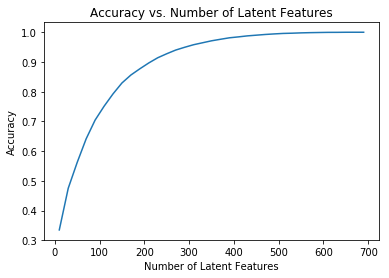

In [48]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [49]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = df_test['user_id'].value_counts().index.tolist()
    test_arts = df_test['article_id'].value_counts().index.tolist()
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [50]:
#how many users can we make predictions for in test set (users that are in both train and test set)
len(set(user_item_test.index).intersection(set(user_item_train.index)))

20

In [51]:
#'How many users in the test set are we not able to make predictions for because of the cold start problem?
len(set(user_item_test.index).difference(set(user_item_train.index)))

662

In [52]:
#'How many movies can we make predictions for in the test set?'
len(set(user_item_test.columns).intersection(set(user_item_train.columns)))

574

In [53]:
#'How many movies in the test set are we not able to make predictions for because of the cold start problem?'
len(set(user_item_test.columns).difference(set(user_item_train.columns)))

0

In [54]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many movies can we make predictions for in the test set?': b,# letter here,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d,# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [55]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

In [56]:
#used Udacity knowledge base to help develop the two cells below

In [57]:
#  user_item_train rows that are in user_item_test
train_rows_in_test = user_item_train.index.isin(user_item_test.index)
u_test = u_train[train_rows_in_test, :]
#  user_item_train columns that are in user_item_test
train_cols_in_test = user_item_train.columns.isin(user_item_test.columns)
#  user_item_test rows that are in user_item_train
test_rows_in_train = user_item_test.index.isin(user_item_train.index)

#creating u_test and vt_test based on train
#no need to create s_test since s_train is equivalent and can be used
u_test = u_train[train_rows_in_test, :]
vt_test = vt_train[:, train_cols_in_test]
# a subset of user_item_test that is contained in train
user_item_test_subset = user_item_test.loc[test_rows_in_train]

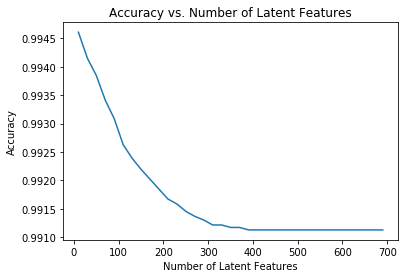

In [58]:
num_latent_feats = np.arange(10, 700+10, 20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_train_new, u_train_new, vt_train_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    
    u_test_new, vt_test_new = u_test[:, :k], vt_test[:k, :]
    
    #take dot product
    user_item_test_preds = np.around(np.dot(np.dot(u_test_new, s_train_new), vt_test_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test_subset, user_item_test_preds)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**
I am unsure how to interpret the results from the previous section. I would expect the test accuracy to generally increase with the number of latent features, and then level out. However, it does the opposite. Have I made some error or is this some indication of overfitting?

We could run some A/B testing to determine if any of these methods of recommendation are an improvement over how users currently find articles.

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the [rubric](https://review.udacity.com/#!/rubrics/2322/view). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [59]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0